# Project description
Write something here

# Create new Conda environment (optional)
You can run with the following command in your conda terminal:
```bash
!conda env create -f environments.yaml
```
Or run the following cell to create a new conda environment.

In [2]:
# uncomment the following line to install the environment
# !conda env create -f environments.yaml
# !conda activate cv_term_project

# Install important packages

In [3]:
# check your Nvidia GPU
!nvidia-smi

Sun May 12 11:45:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8              8W /   75W |     299MiB /   4096MiB |     39%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install PyTorch macthing with your CUDA version
You can check the compatible version of PyTorch with your CUDA version [here](https://pytorch.org/get-started/locally/)

In [4]:
# for my machine (RTX 3050 Laptop)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [5]:
# check CUDA device
import torch
print(torch.__version__)
print(torch.cuda.get_device_name(0))

2.2.2+cu121
NVIDIA GeForce RTX 3050 Laptop GPU


### Other packages

In [6]:
!pip install ipywidgets tqdm numpy matplotlib scikit-learn opencv-python pandas pillow kaggle ultralytics gdown PyYAML

In [7]:
import os
import shutil
import zipfile
import json
import random

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import cv2
import sklearn

In [8]:
# set random seed
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Download dataset from Kaggle
Please put the kaggle.json into the same directory of this notebook

In [9]:
# check if the kaggle.json file exists
from sys import platform

# Windows
# C:\Users\<Windows-username>\.kaggle\kaggle.json
if platform == "win32":
    print("Windows")
    kaggle_json_path = os.path.join(os.path.expanduser("~"), ".kaggle", "kaggle.json")
    if os.path.exists(kaggle_json_path):
        print("kaggle.json exists")
    else:
        print("kaggle.json does not exist")
        shutil.copy("./kaggle.json", kaggle_json_path)
        print("kaggle.json is copied to the directory")

# Linux
# ~/.kaggle/kaggle.json
elif platform == "linux" or platform == "linux2":
    print("Linux")
    kaggle_json_path = os.path.join(os.path.expanduser("~"), ".kaggle", "kaggle.json")
    if os.path.exists(kaggle_json_path):
        print("kaggle.json exists")
    else:
        print("kaggle.json does not exist")
        os.makedirs(os.path.join(os.path.expanduser("~"), ".kaggle"), exist_ok=True)
        shutil.copy("./kaggle.json", kaggle_json_path)
        print("kaggle.json is copied to the directory")

# macOS
# ~/.kaggle/kaggle.json
elif platform == "darwin":
    print("macOS")
    kaggle_json_path = os.path.join(os.path.expanduser("~"), ".kaggle", "kaggle.json")
    if os.path.exists(kaggle_json_path):
        print("kaggle.json exists")
    else:
        print("kaggle.json does not exist")
        os.makedirs(os.path.join(os.path.expanduser("~"), ".kaggle"), exist_ok=True)
        shutil.copy("./kaggle.json", kaggle_json_path)
        print("kaggle.json is copied to the directory")

Windows
kaggle.json exists


In [10]:
# download and unzip the dataset
if(os.path.exists("./rice-image-dataset-for-object-segmentation")):
    print("The dataset is already downloaded")
else:
    !kaggle datasets download -d alikhalilit98/rice-image-dataset-for-object-segmentation
    with zipfile.ZipFile("rice-image-dataset-for-object-segmentation.zip", 'r') as zip_ref:
        zip_ref.extractall("./rice-image-dataset-for-object-segmentation")

The dataset is already downloaded


# Data Preprocessing
The dataset is not appropriate for image segmentation because each image has a single object. We need to synthesize the dataset to have multiple objects in each image.

The current format of the label is in the "labelme" format. We need to convert them to the YOLO segmentation format.

./rice-image-dataset-for-object-segmentation/Rice_Image_Dataset_Seg\Karacadag\Karacadag (2684).jpg
255
(250, 250, 3)


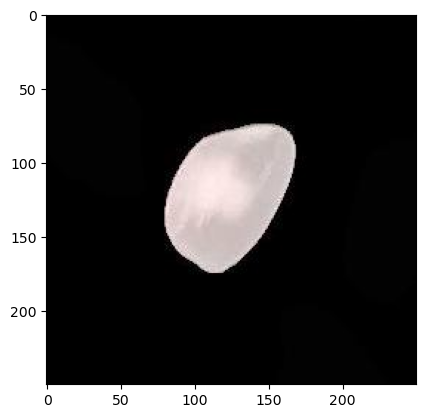

In [42]:
# let's take a look at the dataset
base_path = "./rice-image-dataset-for-object-segmentation/Rice_Image_Dataset_Seg"
type_list = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
random_type_path = os.path.join(base_path, random.choice(type_list))
random_image_path = os.path.join(random_type_path, random.choice([f for f in os.listdir(random_type_path) if f.endswith(".jpg")]))

image = cv2.imread(random_image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image)
print(random_image_path)

print(np.max(image))
print(image.shape)

In [43]:
# label of the image
random_json_path = random_image_path.replace(".jpg", ".json")
with open(random_json_path) as f:
    data = json.load(f)
    display(data)

{'version': '5.0.2',
 'flags': {},
 'shapes': [{'label': 'Karacadag',
   'points': [[140, 74],
    [139, 75],
    [135, 75],
    [134, 76],
    [131, 76],
    [130, 77],
    [128, 77],
    [127, 78],
    [122, 78],
    [121, 79],
    [119, 79],
    [118, 80],
    [115, 80],
    [114, 81],
    [112, 81],
    [111, 82],
    [109, 82],
    [108, 83],
    [107, 83],
    [104, 86],
    [103, 86],
    [102, 87],
    [101, 87],
    [101, 88],
    [98, 91],
    [98, 92],
    [95, 95],
    [95, 96],
    [92, 99],
    [92, 100],
    [91, 101],
    [91, 102],
    [90, 103],
    [90, 104],
    [89, 105],
    [89, 106],
    [87, 108],
    [87, 109],
    [86, 110],
    [86, 111],
    [85, 112],
    [85, 115],
    [84, 116],
    [84, 117],
    [83, 118],
    [83, 120],
    [82, 121],
    [82, 124],
    [81, 125],
    [81, 129],
    [80, 130],
    [80, 142],
    [81, 143],
    [81, 147],
    [82, 148],
    [82, 149],
    [83, 150],
    [83, 151],
    [84, 152],
    [84, 153],
    [85, 154],
    [85, 1

## YOLO segmentation format

### The directory structure of the dataset should be as follows:
```bash
data
├── images
│   ├── train
│   │   ├── 0.jpg
│   │   ├── 1.jpg
│   │   ├── ...
│   ├── val
│   │   ├── 0.jpg
│   │   ├── 1.jpg
│   │   ├── ...
├── labels
│   ├── train
│   │   ├── 0.txt
│   │   ├── 1.txt
│   │   ├── ...
│   ├── val
│   │   ├── 0.txt
│   │   ├── 1.txt
│   │   ├── ...
```



### The format of the label files of YOLO segmentation should be as follows:
```bash
<cls-index> <x1> <y1> <x2> <y2> ... <xn> <yn>
<cls-index> <x1> <y1> <x2> <y2> ... <xn> <yn>
```
Where:
- `<cls-index>`: The index of the class in the class list.
- `<x1> <y1> <x2> <y2> ... <xn> <yn>`: The coordinates of the polygon, normalized by width and height of the image.

In [45]:
# get list of path of images of each type
base_path = "./rice-image-dataset-for-object-segmentation/Rice_Image_Dataset_Seg"
arborio_list = [f for f in os.listdir(os.path.join(base_path, "Arborio")) if f.endswith(".jpg")]
basmati_list = [f for f in os.listdir(os.path.join(base_path, "Basmati")) if f.endswith(".jpg")]
ipsala_list = [f for f in os.listdir(os.path.join(base_path, "Ipsala")) if f.endswith(".jpg")]
jasmine_list = [f for f in os.listdir(os.path.join(base_path, "Jasmine")) if f.endswith(".jpg")]
karacadag_list = [f for f in os.listdir(os.path.join(base_path, "Karacadag")) if f.endswith(".jpg")]

In [46]:
# print the number of images of each type
print("Arboria:", len(arborio_list))
print("Basmati:", len(basmati_list))
print("Ipsala:", len(ipsala_list))
print("Jasmine:", len(jasmine_list))
print("Karacadag:", len(karacadag_list))

Arboria: 15000
Basmati: 15000
Ipsala: 15000
Jasmine: 15000
Karacadag: 15000


In [198]:
'''# We will not use the entire dataset, since it is too large.
# We will use only 6000 images of jasmine and 1500 for the rest of the types.

random.seed(random_seed)

# random pick 6000 images from jasmine with random seed
jasmine_subset = random.sample(jasmine_list, 6000)
jasmine_subset = list(map(lambda x: f"Jasmine/{x}", jasmine_subset))

# random pick 1500 images from the rest of the types with random seed
arborio_subset = random.sample(arborio_list, 1500)
arborio_subset = list(map(lambda x: f"Arborio/{x}", arborio_subset))

basmati_subset = random.sample(basmati_list, 1500)
basmati_subset = list(map(lambda x: f"Basmati/{x}", basmati_subset))

ipsala_subset = random.Random(random_seed).sample(ipsala_list, 1500)
ipsala_subset = list(map(lambda x: f"Ipsala/{x}", ipsala_subset))

karacadag_subset = random.sample(karacadag_list, 1500)
karacadag_subset = list(map(lambda x: f"Karacadag/{x}", karacadag_subset))'''

In [199]:
'''# split the dataset into train and validation sets
from sklearn.model_selection import train_test_split

# Jasmine
jasmine_train, jasmine_val = train_test_split(jasmine_subset, test_size=0.1, random_state=random_seed)

# Non-Jasmine
arborio_train, arborio_val = train_test_split(arborio_subset, test_size=0.1, random_state=random_seed)
basmati_train, basmati_val = train_test_split(basmati_subset, test_size=0.1, random_state=random_seed)
ipsala_train, ipsala_val = train_test_split(ipsala_subset, test_size=0.1, random_state=random_seed)
karacadag_train, karacadag_val = train_test_split(karacadag_subset, test_size=0.1, random_state=random_seed)

non_jasmine_train = arborio_train + basmati_train + ipsala_train + karacadag_train
non_jasmine_val = arborio_val + basmati_val + ipsala_val + karacadag_val'''

In [47]:
jasmine_subset = list(map(lambda x: f"Jasmine/{x}", jasmine_list))

arborio_subset = list(map(lambda x: f"Arborio/{x}", arborio_list))

basmati_subset = list(map(lambda x: f"Basmati/{x}", basmati_list))

ipsala_subset = list(map(lambda x: f"Ipsala/{x}", ipsala_list))

karacadag_subset = list(map(lambda x: f"Karacadag/{x}", karacadag_list))

In [48]:
# split the dataset into train and validation sets
from sklearn.model_selection import train_test_split

# Jasmine
jasmine_train, jasmine_val = train_test_split(jasmine_subset, test_size=0.2, random_state=random_seed)

# Non-Jasmine
arborio_train, arborio_val = train_test_split(arborio_subset, test_size=0.2, random_state=random_seed)
basmati_train, basmati_val = train_test_split(basmati_subset, test_size=0.2, random_state=random_seed)
ipsala_train, ipsala_val = train_test_split(ipsala_subset, test_size=0.2, random_state=random_seed)
karacadag_train, karacadag_val = train_test_split(karacadag_subset, test_size=0.2, random_state=random_seed)

non_jasmine_train = arborio_train[:3000] + basmati_train[:3000] + ipsala_train[:3000] + karacadag_train[:3000]
non_jasmine_val = arborio_val[:750] + basmati_val[:750] + ipsala_val[:750] + karacadag_val[:750]

In [49]:
print("Jasmine Train:", len(jasmine_train))
print("Jasmine Val:", len(jasmine_val))
print("Non-Jasmine Train:", len(non_jasmine_train))
print("Non-Jasmine Val:", len(non_jasmine_val))

Jasmine Train: 12000
Jasmine Val: 3000
Non-Jasmine Train: 12000
Non-Jasmine Val: 3000


## Synthesis data generation
Since the dataset is not appropriate for image segmentation, we need to synthesize the dataset to have multiple objects in each image.

### We will randomly generate the following parameters: 
Number of rice grains => [20, 30, 40, 50]

Ratio of Jasmine rice => [0.4, 0.5, 0.6, 0.7, 0.8]

Size of the image (we will resize each rice image to 125*125) => [(1080, 1080), (1024, 768), (1280, 720)] # square, 4:3, 16:9

Background color/texture => [black, dark gray, green, metal, wood]

In [75]:
# download texture
import gdown
gdown.download_folder("https://drive.google.com/drive/folders/1rtXrai27tT2MA2vt8d4_dl7T94kkfnGT")

Retrieving folder contents


Processing file 12xWj-d2pQXXGMvuwLRpQQMqoYi_BksbY fabric1.jpg
Processing file 1kao4dbE27Vhh8iybyA_h_Mr3z-dZdCTh fabric2.jpg
Processing file 1oHO_8EyYDHh9iOVYW1CBaZ-eo8XdkzV6 marble1.jpg
Processing file 1n3KBbdBM-DCVESc5PnB1ZPRYtSw6lTjc marble2.jpg
Processing file 152tXCyPDsFrjCluGsbXda7nry6i7Uroo metal1.jpg
Processing file 13ecwU44XMnzG7SRV0bJX5AC4QIgLrw-G metal2.jpg
Processing file 1M6xv5wpJVl8fP4Q-uSUATymFZzhff4n9 wood1.jpg
Processing file 1vVgWAScXG7KIsHwhiIfsE-vr9unwh98q wood2.jpg


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=12xWj-d2pQXXGMvuwLRpQQMqoYi_BksbY
To: c:\Users\chant\Desktop\CV_Project\ComputerVision_STA_Project\Texture\fabric1.jpg
100%|██████████| 24.4M/24.4M [00:00<00:00, 34.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kao4dbE27Vhh8iybyA_h_Mr3z-dZdCTh
To: c:\Users\chant\Desktop\CV_Project\ComputerVision_STA_Project\Texture\fabric2.jpg
100%|██████████| 5.31M/5.31M [00:00<00:00, 21.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oHO_8EyYDHh9iOVYW1CBaZ-eo8XdkzV6
To: c:\Users\chant\Desktop\CV_Project\ComputerVision_STA_Project\Texture\marble1.jpg
100%|██████████| 8.35M/8.35M [00:00<00:00, 33.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n3KBbdBM-DCVESc5PnB1ZPRYtSw6lTjc
To: c:\Users\chant\Desktop\CV_Project\ComputerVision_STA_Project\Texture\marble2.jpg
100%|██████████| 28.1M/28.1M [00:00<00:00, 36.3MB/s]

['c:\\Users\\chant\\Desktop\\CV_Project\\ComputerVision_STA_Project\\Texture\\fabric1.jpg',
 'c:\\Users\\chant\\Desktop\\CV_Project\\ComputerVision_STA_Project\\Texture\\fabric2.jpg',
 'c:\\Users\\chant\\Desktop\\CV_Project\\ComputerVision_STA_Project\\Texture\\marble1.jpg',
 'c:\\Users\\chant\\Desktop\\CV_Project\\ComputerVision_STA_Project\\Texture\\marble2.jpg',
 'c:\\Users\\chant\\Desktop\\CV_Project\\ComputerVision_STA_Project\\Texture\\metal1.jpg',
 'c:\\Users\\chant\\Desktop\\CV_Project\\ComputerVision_STA_Project\\Texture\\metal2.jpg',
 'c:\\Users\\chant\\Desktop\\CV_Project\\ComputerVision_STA_Project\\Texture\\wood1.jpg',
 'c:\\Users\\chant\\Desktop\\CV_Project\\ComputerVision_STA_Project\\Texture\\wood2.jpg']

In [92]:
from pathlib import Path
Path("./dataset").mkdir(parents=True, exist_ok=True)

Path("./dataset/images").mkdir(parents=True, exist_ok=True)
Path("./dataset/images/train").mkdir(parents=True, exist_ok=True)
Path("./dataset/images/val").mkdir(parents=True, exist_ok=True)

Path("./dataset/labels").mkdir(parents=True, exist_ok=True)
Path("./dataset/labels/train").mkdir(parents=True, exist_ok=True)
Path("./dataset/labels/val").mkdir(parents=True, exist_ok=True)

In [91]:
# shutil.rmtree("./dataset")

In [93]:
# synthesis parameters

number_of_syn_train_images = 200
number_of_syn_val_images = 40
ratio_of_unlabeled = 0.05 # aka. background

syn_parameters = {
    "number_of_rice": [20, 30, 40, 50],
    "ratio_of_jasmine": [0.4, 0.5, 0.6, 0.7, 0.8],
    "size_of_image": [(1920, 1080), (1080, 1080), (1024, 768), (1280, 720)],
    "texture": ["black", "darkgray", "green", "darkgreen", "metal1", "metal2", "fabric1", "fabric2", "wood1", "wood2", "marble1", "marble2"]
}

In [94]:
from PIL import Image, ImageDraw
from tqdm import tqdm

def synthesisAndFormat(jasmine_dataset, non_jasmine_dataset, dataset_type, number_of_syn_images):
    
    if dataset_type not in ["train", "val"]:
        raise ValueError("dataset_type must be either 'train' or 'val'")
    
    random.seed(random_seed)
    
    for i in tqdm(range(np.ceil(number_of_syn_images*(1+ratio_of_unlabeled))), desc="Processing images"):    
        # random the parameters
        number_of_rice = random.choice(syn_parameters["number_of_rice"])
        ratio_of_jasmine = random.choice(syn_parameters["ratio_of_jasmine"])
        size_of_image = random.choice(syn_parameters["size_of_image"])
        texture = random.choice(syn_parameters["texture"])
        # print(number_of_rice, ratio_of_jasmine, size_of_image, texture)

        # get/generate the background
        if texture not in ["black", "darkgray", "green", "darkgreen"]:
            texture_path = f"./Texture/{texture}.jpg"
            background = Image.open(texture_path).resize(size_of_image)
        else:
            background = Image.new("RGB", size_of_image, color=texture)
        
        # set the save path
        base_path = "./rice-image-dataset-for-object-segmentation/Rice_Image_Dataset_Seg"
        img_save_path = f"./dataset/images/{dataset_type}/syn_{i}.jpg"
        label_save_path = f"./dataset/labels/{dataset_type}/syn_{i}.txt"
        
        # add background images and empty labels (this might help to reduce False Positive)
        if i >= number_of_syn_images:
            background.save(img_save_path)
            # create an empty label file
            with open(label_save_path, "w") as label_file:
                pass
            continue
            
        # randomly pick jasmine and non-jasmine rices
        number_of_jasmine = int(number_of_rice * ratio_of_jasmine)
        number_of_non_jasmine = number_of_rice - number_of_jasmine
        
        picked_jasmine = random.sample(jasmine_dataset, number_of_jasmine)
        picked_non_jasmine = random.sample(non_jasmine_dataset, number_of_non_jasmine)
        
        lines = [] # store the lines of the label file
        
        # paste the rice images to the background
        for image_name in picked_jasmine + picked_non_jasmine:
            image_path = f"{base_path}/{image_name}"
            json_path = image_path.replace(".jpg", ".json")
            
            rice_image = Image.open(image_path).resize((125, 125)) # original image is (250, 250)
            with open(json_path) as json_file:
                data = json.load(json_file)
                points = data["shapes"][0]["points"]
                label = 0 if data["shapes"][0]["label"] == "Jasmine" else 1 # 0 for Jasmine, 1 for the rest
                
            resized_points = [(point[0]//2, point[1]//2) for point in points]
            
            # Create a new image with the same size as the original image, filled with black
            mask = Image.new('L', (125, 125), 0)

            # Draw the polygon defined by `resized_points` onto `mask` in white
            ImageDraw.Draw(mask).polygon(resized_points, outline=1, fill=1)
            
            # Convert the mask to a NumPy array and scale it to the range [0, 255]
            mask_np = np.array(mask) * 255
            
            # Use the mask to extract the segmented area from the original image
            segmented_area = Image.fromarray(np.array(rice_image) * (mask_np[:, :, None] / 255).astype('uint8'))
            
            # paste the segmented area to the background
            random_coor = (random.randint(0, size_of_image[0]-125), random.randint(0, size_of_image[1]-125))
            background.paste(segmented_area, random_coor, mask=Image.fromarray(mask_np))
            
            # append the label to the lines
            line = f"{label}"
            for point in resized_points:
                x = round((point[0] + random_coor[0]) / size_of_image[0], 4)
                y = round((point[1] + random_coor[1]) / size_of_image[1], 4)
                line += f" {x} {y}"
            lines.append(line)
            
        # save the image and label
        background.save(img_save_path)
        with open(label_save_path, "w") as label_file:
            label_file.writelines("\n".join(lines))

In [95]:
import concurrent.futures

with concurrent.futures.ThreadPoolExecutor() as executor:
    future1 = executor.submit(synthesisAndFormat, jasmine_train, non_jasmine_train, "train", number_of_syn_train_images)
    future2 = executor.submit(synthesisAndFormat, jasmine_val, non_jasmine_val, "val", number_of_syn_val_images)

Processing images: 100%|██████████| 210/210 [01:06<00:00,  3.15it/s]


In [84]:
print("number of train images", len(os.listdir("./dataset/images/train")))
print("number of train labels", len(os.listdir("./dataset/labels/train")))
print("number of val images", len(os.listdir("./dataset/images/val")))
print("number of val labels", len(os.listdir("./dataset/labels/val")))

number of train images 200
number of train labels 200
number of val images 40
number of val labels 40


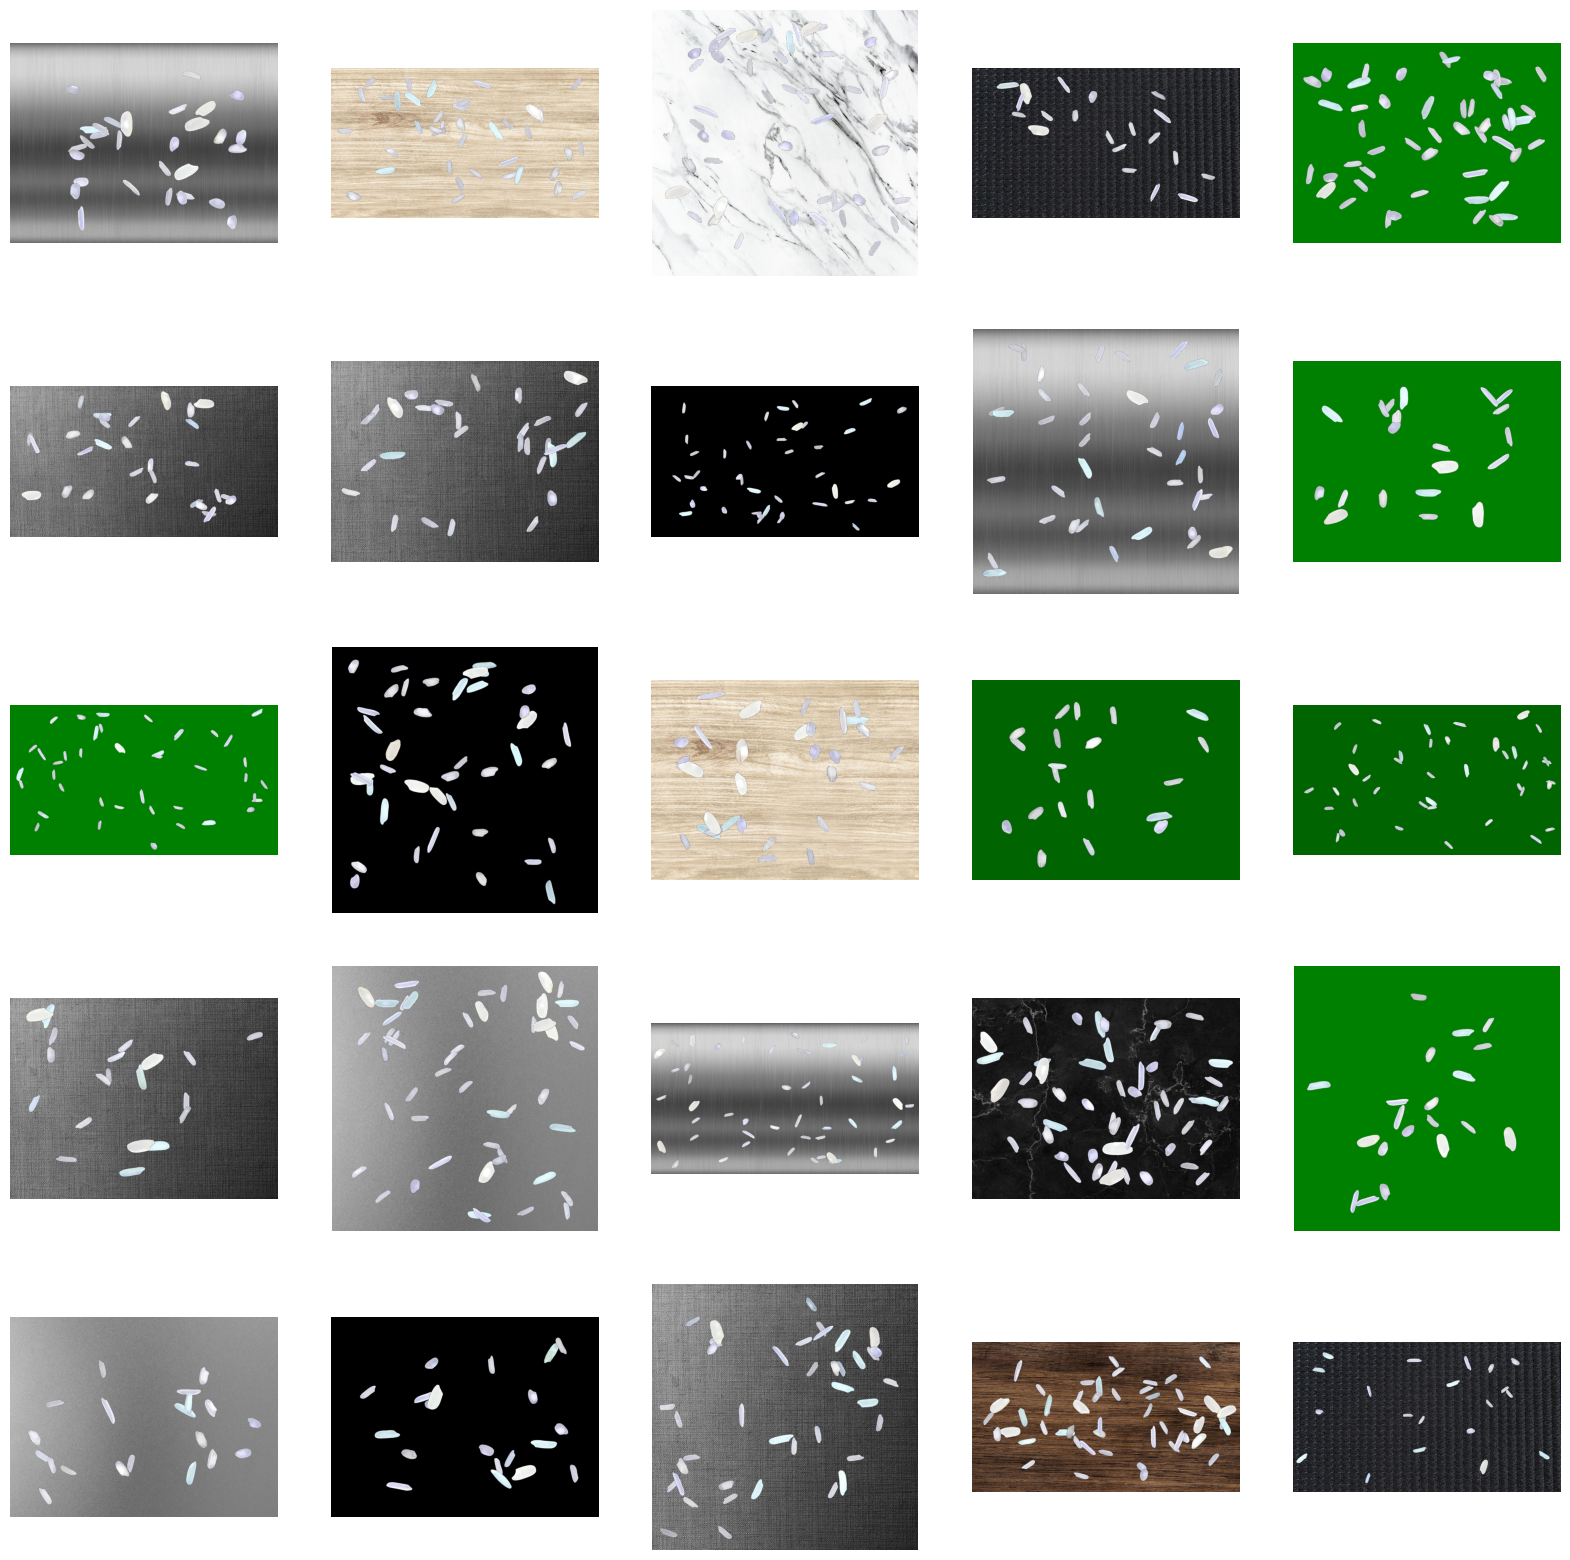

In [85]:
# let's take a look at the synthesized images
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.ravel()
syn_image_path = os.listdir("./dataset/images/train")
sample_syn_image = random.sample(syn_image_path, 25)
for i in range(25):
    random_image = cv2.imread(f"./dataset/images/train/{sample_syn_image[i]}")
    random_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(random_image)
    axes[i].axis("off")
plt.show()

### The format of the yaml file should be as follows:
```bash
# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../datasets/coco8-seg  # dataset root dir
train: images/train  # train images (relative to 'path') 4 images
val: images/val  # val images (relative to 'path') 4 images
test:  # test images (optional)

# Classes (80 COCO classes)
names:
  0: person
  1: bicycle
  2: car
  # ...
  77: teddy bear
  78: hair drier
  79: toothbrush
```

[source](https://docs.ultralytics.com/datasets/segment/#ultralytics-yolo-format)

In [230]:
import yaml

full_path = os.path.abspath("dataset")

yaml_data = dict(
    path = full_path,
    train = "images/train",
    val = "images/val",
    names = [{0: "Jasmine"}, {1: "Non-Jasmine"}]
)

with open("dataset/data.yaml", "w") as f:
    yaml.dump(yaml_data, f, default_flow_style=False, sort_keys=False)

# Training YOLO Segmentation model

In [ ]:
from ultralytics import YOLO

seg_model = YOLO("yolov8l-seg.pt")

yaml_full_path = full_path = os.path.abspath("./dataset/data.yaml")
trained_seg_model = seg_model.train(data=yaml_full_path, epochs=20, batch=8, imgsz=640, device="0", project="rice_segmentation", name="run1", seed=random_seed)